# Predict Internet Use via XGBoost

- **[Loaded the Data From a File](#download-the-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**

# Import the modules


In [2]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

----

<a id="download-the-data"></a>
# Import the data

This dataset has been cleaned previously in R. 

These things were done:
1. remove columns with more than 10% NA
2. remove character columns
3. remove id columns and the likes
4. delete values like 9999 and 9998, which are "Refused" and "Don't Know/ NA"
5. remove participants with missing outcome
6. remove variables with near zero variance

In [3]:
df = pd.read_csv('h16f2a_cleaned_010221.csv')
df.head()

,PA009,PA012,PA019,PA028,PA099,PA100,PA101,PA106,PA113,PVDATE,...,PJF478,PQR012,PQR010,PQR011,PJR478A,PF_CPL,PQ488_1A,PQ488_2A,PQ488_3A,COHORT
0,1,1,76,5,0,0,0,0,0,3,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
1,1,1,60,5,0,0,0,0,0,2,...,1.0,5.0,5.0,5.0,1.0,0,NaN,0.0,0.0,3
2,1,1,70,5,0,2,2,2,4,3,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
3,1,1,68,5,0,1,1,1,2,2,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
4,1,1,79,5,0,2,2,2,4,2,...,1.0,5.0,5.0,5.0,1.0,1,0.0,0.0,0.0,3



----

<a id="format-the-data"></a>
# Split the Data into Dependent and Independent Variables


In [4]:
X = df.drop('PW303', axis=1).copy()
X.head()

,PA009,PA012,PA019,PA028,PA099,PA100,PA101,PA106,PA113,PVDATE,...,PJF478,PQR012,PQR010,PQR011,PJR478A,PF_CPL,PQ488_1A,PQ488_2A,PQ488_3A,COHORT
0,1,1,76,5,0,0,0,0,0,3,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
1,1,1,60,5,0,0,0,0,0,2,...,1.0,5.0,5.0,5.0,1.0,0,NaN,0.0,0.0,3
2,1,1,70,5,0,2,2,2,4,3,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
3,1,1,68,5,0,1,1,1,2,2,...,1.0,5.0,5.0,5.0,1.0,0,0.0,0.0,0.0,3
4,1,1,79,5,0,2,2,2,4,2,...,1.0,5.0,5.0,5.0,1.0,1,0.0,0.0,0.0,3


In [5]:
df['PW303'].replace({1:1, 5:0}, inplace=True)
y = df['PW303'].copy()
y.head()

0    0
1    0
2    1
3    1
4    1
Name: PW303, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a model with **XGBoost**.

----

<a id="one-hot-encoding"></a>
# Treat Categorical Predictors: One-Hot Encoding


In [6]:
#note that this list has some columns that had zero variance that were removed already in X, so we need to find the intersection
df1 = pd.read_csv('possible_categorical.csv')
possible_categorical = df1['x'].tolist()
#this is the list of categorical columns that will turn into dummies
cat_col = list(set(possible_categorical).intersection(list(X)))

In [7]:
X_encoded = pd.get_dummies(X, columns = cat_col)
X_encoded.head() #now we have categorical columns turned into dummies

,PA019,PA100,PA101,PA106,PA113,PVDATE,PB132,PC139,PC229,PD182M1,...,PZ023_3.0,PZ023_4.0,PZ023_5.0,PZ023_6.0,PZ023_7.0,PN067_1.0,PN067_5.0,PC128_1.0,PC128_3.0,PC128_5.0
0,76,0,0,0,0,3,8.0,140.0,0.0,17.0,...,1,0,0,0,0,0,1,0,0,1
1,60,0,0,0,0,2,0.0,190.0,3.0,1.0,...,1,0,0,0,0,0,1,0,0,1
2,70,2,2,2,4,3,9.0,150.0,0.0,19.0,...,1,0,0,0,0,1,0,1,0,0
3,68,1,1,1,2,2,6.0,131.0,0.0,16.0,...,1,0,0,0,0,0,1,0,0,1
4,79,2,2,2,4,2,8.0,160.0,0.0,4.0,...,1,0,0,0,0,0,1,1,0,0


In [7]:
print ('We have ' + str(len(X_encoded)) + ' observations and ' + str(len(X_encoded.columns)) + ' predictors (including dummies).')

We have 20738 observations and 851 predictors (including dummies).



----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making an **XGBoost** model. Now we simply split the data into **training** and **testing** data sets and build the model. However, first, let's observe that this dataset is balanced.

In [8]:
sum(y)/len(y)

0.5692930851576815

We see that **56.9%** of the people in the dataset are internet users.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

The train and test sets are also balanced.

In [10]:
sum(y_train)/len(y_train)

0.5719796823763904

In [11]:
sum(y_test)/len(y_test)

0.5612343297974928

**NOTE:** Instead of determining the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer improve the situation.

In [12]:
import sklearn
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.85316
[1]	validation_0-aucpr:0.86764
[2]	validation_0-aucpr:0.87526
[3]	validation_0-aucpr:0.87967
[4]	validation_0-aucpr:0.88243
[5]	validation_0-aucpr:0.88642
[6]	validation_0-aucpr:0.88912
[7]	validation_0-aucpr:0.89061
[8]	validation_0-aucpr:0.89074
[9]	validation_0-aucpr:0.89194
[10]	validation_0-aucpr:0.89359
[11]	validation_0-aucpr:0.89358
[12]	validation_0-aucpr:0.89519
[13]	validation_0-aucpr:0.89556
[14]	validation_0-aucpr:0.89658
[15]	validation_0-aucpr:0.89638
[16]	validation_0-aucpr:0.89760
[17]	validation_0-aucpr:0.89787
[18]	validation_0-aucpr:0.89800
[19]	validation_0-aucpr:0.89834
[20]	validation_0-aucpr:0.89826
[21]	validation_0-aucpr:0.89872
[22]	validation_0-aucpr:0.89872
[23]	validation_0-aucpr:0.89817
[24]	validation_0-aucpr:0.89806
[25]	validation_0-aucpr:0.89730
[26]	validation_0-aucpr:0.89669
[27]	validation_0-aucpr:0.89702
[28]	validation_0-aucpr:0.89714
[29]	validation_0-aucpr:0.89668
[30]	validation_0-aucpr:0.89642
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

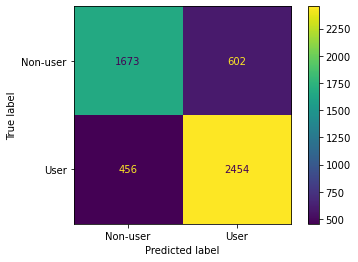

In [15]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Non-user", "User"])

In [18]:
a = (1673+2454)/(1673+2454+602+456)
print ('The out-of-sample prediction accuracy is ' + str(a))

The out-of-sample prediction accuracy is 0.7959498553519768


Now we have a **XGBoost** model using only the default hyperparameters.


----

<a id="optimize-parameters"></a>
# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manually configure and are not determined by **XGBoost** itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [31]:
# ROUND 1
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
# }
# Output: 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1.0}
# 45 minutes
# max depth and reg_lambda look good
# Because learning_rate and gamma were at the ends of their range, we will continue to explore those...

## ROUND 2
# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1, 0.5, 1],
#     'gamma': [1.0, 3.0, 5.0, 10.0],
#     'reg_lambda': [1.0, 5.0],
# }
# Output: {'gamma': 5.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1.0}

# NOTE: To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree.
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, 
#                    y_train, 
#                    early_stopping_rounds=10,                
#                    eval_metric='auc',
#                    eval_set=[(X_test, y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)

So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=5.0`, `learn_rate=0.1`, `max_depth=4`, and `reg_lambda=1.0`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [12]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=5.0,
                        learn_rate=0.1,
                        max_depth=4,
                        reg_lambda=1.0,
                        subsample=0.9,
                        colsample_bytree=0.5)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[18:04:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.81488
[1]	validation_0-aucpr:0.85122
[2]	validation_0-aucpr:0.86764
[3]	validation_0-aucpr:0.87465
[4]	validation_0-aucpr:0.87996
[5]	validation_0-aucpr:0.88253
[6]	validation_0-aucpr:0.88409
[7]	validation_0-aucpr:0.88609
[8]	validation_0-aucpr:0.88799
[9]	validation_0-aucpr:0.89050
[10]	validation_0-aucpr:0.89218
[11]	validation_0-aucpr:0.89409
[12]	validation_0-aucpr:0.89496
[13]	validation_0-aucpr:0.89728
[14]	validation_0-aucpr:0.89799
[15]	validation_0-aucpr:0.89806
[16]	validation_0-aucpr:0.89804
[17]	validation_0-aucpr:0.89840
[18]	validation_0-aucpr:0.89882
[19]	validation_0-aucpr:0.89932
[20]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1.0,
              scale_pos_weight=1, seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

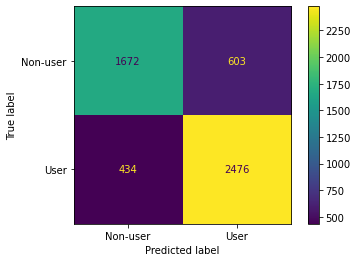

In [14]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Non-user", "User"])

In [16]:
b = (1672+2476)/(1672+2476+603+434)
print ('The out-of-sample prediction accuracy is ' + str(b))

The out-of-sample prediction accuracy is 0.8


In [30]:
x = clf_xgb.get_booster().get_score(importance_type="gain")
dict(sorted(x.items(), key=lambda item: item[1], reverse=True))


{'PD240_1.0': 558.32946576,
 'PQR011_5.0': 412.56048599999997,
 'PG040_5.0': 264.295520675,
 'PP005': 207.9834083833333,
 'PD186': 190.9516550666667,
 'PNSSCORE': 157.67088203461537,
 'PN164_5.0': 151.9371148,
 'PQ162_5.0': 132.981506,
 'PQ344_1.0': 115.31477866666667,
 'PQ162_1.0': 111.774643,
 'PQ370_1.0': 97.3352966,
 'PD184': 95.7676359325,
 'PP155': 95.10874337999999,
 'PN164_1.0': 80.5428619,
 'PP097_3.0': 74.6907282,
 'PN098_2': 74.07551559999999,
 'PG198_5.0': 71.15340975000001,
 'PNSSCORESE': 69.2861538,
 'PQ344_5.0': 66.24606332500001,
 'PD176': 65.66795406499999,
 'PA012_1': 56.2859383,
 'P025_1.0': 54.3916206,
 'PA019': 51.12395854999998,
 'PG086_5.0': 51.0143566,
 'PD240_5.0': 47.4589233,
 'PN023': 45.62172795,
 'PN067_5.0': 42.8066559,
 'PC128_5.0': 39.741863275,
 'PQ375_1.0': 39.1147041,
 'PC128_1.0': 38.217050775000004,
 'PTN05_5': 37.4606031,
 'PQ453_5.0': 36.03468705,
 'PX060_R_2': 35.15820791666666,
 'PQR010_1.0': 33.8315849,
 'PN098_1': 32.3994141,
 'PQ426': 30.8742

# Here are the top 15 important predictors:

PD240_1.0: number series 2, 4, 6 - correct

PQR011_5.0: who worked for pay last calendar year? (spouse, self, both?)

PG040_5.0: have difficulty using a map - no

PP005: what are the chances that you and your partner will leave an inheritance totaling $10,000 or more?

PD186:  NUMBER FORGOTTEN - DELAYED


PNSSCORE: The standard error of number series score

PN164_5.0: in the last two year, have you seen a dentist for dental care, including dentures? - no

PQ162_5.0: have money in IRA account?

PQ344_1.0: have any checking or savings accounts or money market funds?

PD184: NUMBER GOOD - DELAYED


PP155: Number of percent range questions asked

PN164_1.0: in the last two year, have you seen a dentist for dental care, including dentures? - yes

PP097_3.0: How closely do you follow the stock market: very closely, somewhat, or not at all?

PN098_2: R'S HEALTH INSURANCE PAYS PART OF PRESCRIPTION AND/OR DENTAL (not true)

PG198_5.0: Have you spent any time in the past 12 months helping friends, neighbors, or relatives who did not live with you and did not pay you for the help?


-----

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**